### Effect of outliers 

The analysis described here assumes that in some regions there 
are potentially two surfaces which may be picked and a 
corresponding scatter in the observations that represent 
contingencies in the sampling of the structure at a site. 

We can re-run the fitting algorithm while omitting each set of incompatible points to look 
at each surface independently. 

Here we plot the results of this analysis: a deep surface and the distance between this
and the shallow surface. The two surfaces coincide to within error in regions where the
quality score is highest. 


--- 

Notebooks in this section:



In [1]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import litho1pt0


In [2]:
## These are the original data 
mohoraw = np.load("Models/AlaskaMohoErrs.npz")['alaska_moho']
mohorawgrid = stripy.sTriangulation(np.radians(mohoraw['lon']), np.radians(mohoraw['lat']), tree=True, permute=False)

## The data retaining the deepest picks of the surface and "discarding" the shallow ones
msmohoF1 = np.load("Models/AlaskaMoHiErrs-AlaskaMohoFineGrid.npz")

## The data retaining the deepest picks of the surface and "discarding" the shallow ones
msmohoF2 = np.load("Models/AlaskaMoLoErrs-AlaskaMohoFineGrid.npz")

In [3]:
lons = msmohoF1['gridlons']
lats = msmohoF1['gridlats']

gridF1 = stripy.sTriangulation(lons%(2.0*np.pi), lats, permute=True)
gridF1_interpolation_1pct_j   = msmohoF1['gridded_data_1']
gridF1_interpolation_1pct_j_s = msmohoF1['gridded_data_slope_1']
gridF1_interpolation   = msmohoF1['gridded_data_2']
gridF1_interpolation_s = msmohoF1['gridded_data_slope_2']
gridF1_quality = msmohoF1['quality']


lons = msmohoF2['gridlons']
lats = msmohoF2['gridlats']

gridF2 = stripy.sTriangulation(lons%(2.0*np.pi), lats, permute=True)
gridF2_interpolation_1pct_j   = msmohoF2['gridded_data_1']
gridF2_interpolation_1pct_j_s = msmohoF2['gridded_data_slope_1']
gridF2_interpolation   = msmohoF2['gridded_data_2']
gridF2_interpolation_s = msmohoF2['gridded_data_slope_2']
gridF2_quality = msmohoF2['quality']


## For various reasons, the grids can be of different sizes ...

gridF2onF1_interpolation, err = gridF2.interpolate(gridF1.lons, gridF1.lats, gridF2_interpolation, order=3)
gridF2onF1_interpolation_1pct_j, err = gridF2.interpolate(gridF1.lons, gridF1.lats, gridF2_interpolation_1pct_j, order=3)



In [13]:
def alaska_moho_delta_plot(filename, 
                           grid, 
                           gridh,
                           data, 
                           datah,
                           quality, 
                           qualityh, 
                           plot_range=[25.0, 50.0], 
                           show_coastline=True,
                           show_bg_image=True,
                           raw_data_points=None,
                           cmap=None ):
    
    goodgrid = grid
    goodgridh = gridh
    interpolation_quality = quality
    interpolation_qualityh = qualityh
    grid_data = data
    grid_datah = datah

    if cmap == None:
        cmap = plt.cm.RdYlBu
        
    if(show_bg_image):
        try:
            import gdal
            globalsrelief      = gdal.Open("../ShadedRelief/GRAY_HR_SR_OB.tif")
            globalsrelief_img  = globalsrelief.ReadAsArray()/255.0  # .transpose(1,2,0)
            globalsrelief_img_q = globalsrelief_img[0:globalsrelief_img.shape[0]//4, 0:globalsrelief_img.shape[1]//4]
        except ImportError:
            show_bg_image = False


    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    
      
    ax1.set_extent([-170,-130,50,70])

    if(show_bg_image):
        ax1.imshow(globalsrelief_img_q**0.5, origin='upper', transform=ccrs.PlateCarree(),
                   extent=[-180,-90,45,90], zorder=0, alpha=1.0, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)
    
    ax1.coastlines(resolution="50m",color="#111111", linewidth=0.5, zorder=99)


    lons = np.degrees(goodgridh.lons)%360.0
    lats = np.degrees(goodgridh.lats)
  
    gdata2 = grid_datah.copy()
    gdata2[ qualityh < 0.1] = -1000000.0
 
    cnt0=ax1.tricontourf(lons, lats, goodgridh.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", linewidths=0.0,
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.25,
                         zorder=11)
 
    gdata2 = grid_datah.copy()
    gdata2[ qualityh == 0] = -1000000.0
 
    cnt0=ax1.tricontourf(lons, lats, goodgridh.simplices, gdata2, 
                   cmap=cmap, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", 
                   transform=ccrs.PlateCarree(),
                         antialiased=True,
                         alpha=0.5,
                         zorder=10)
 

    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)


    centroids_q, err = goodgrid.interpolate(goodgrid.lons[goodgrid.simplices].mean(axis=1), 
                                            goodgrid.lats[goodgrid.simplices].mean(axis=1), quality)
    
    
    mask = centroids_q == 0.0

    cnt=ax1.tricontour(lons, lats, goodgrid.simplices, grid_data, 
                   alpha=1.0, colors="#000000", 
                   levels=[-15, -10, -5,  5.0],
                   linewidths=[1.0, 0.75, 0.5, 0.5],
                   linestyles=["-","-", "-", ":"],
                   transform=ccrs.PlateCarree(), 
                       zorder=50) 
  
    
    ## Locations of raw data collection

    if raw_data_points is not None:
        m = ax1.scatter(raw_data_points['lon'], raw_data_points['lat'],  color="Black",
                       edgecolor="Black", linewidth=0.5, 
                       marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

   
    fig.savefig(filename, dpi=600)

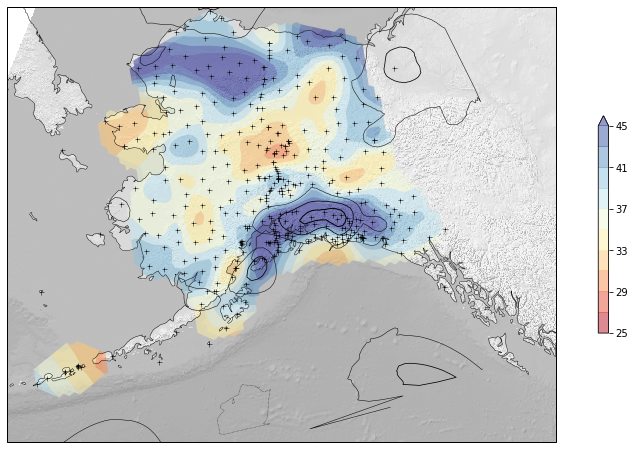

In [14]:
delta = gridF2onF1_interpolation - gridF1_interpolation

alaska_moho_delta_plot("Images/AlaskaMohoDelta.png", 
                        gridF1, 
                        gridF1,
                        delta, 
                        gridF1_interpolation,
                        gridF1_quality, 
                        gridF1_quality, 
                        plot_range=[25, 45],
                        show_bg_image=True,
                        raw_data_points=mohoraw,
                       )

In [15]:
llo, lla = stripy.spherical.great_circle_Npoints(np.radians([-149, 60]), np.radians([-149, 70]), 100)

lls = np.recarray(shape=(llo.shape), formats=['f8', 'f8'], names=['lon', 'lat'])

lls['lon'] = np.degrees(llo)
lls['lat'] = np.degrees(lla)

moho_line1,  err = gridF1.interpolate(llo,lla, gridF1_interpolation)
moho_line2,  err = gridF2.interpolate(llo,lla, gridF2_interpolation)
moho_lineR,  err = mohorawgrid.interpolate(llo,lla, mohoraw['moh'])

pts = np.logical_and(mohoraw['lon'] < -148, mohoraw['lon'] > -150)

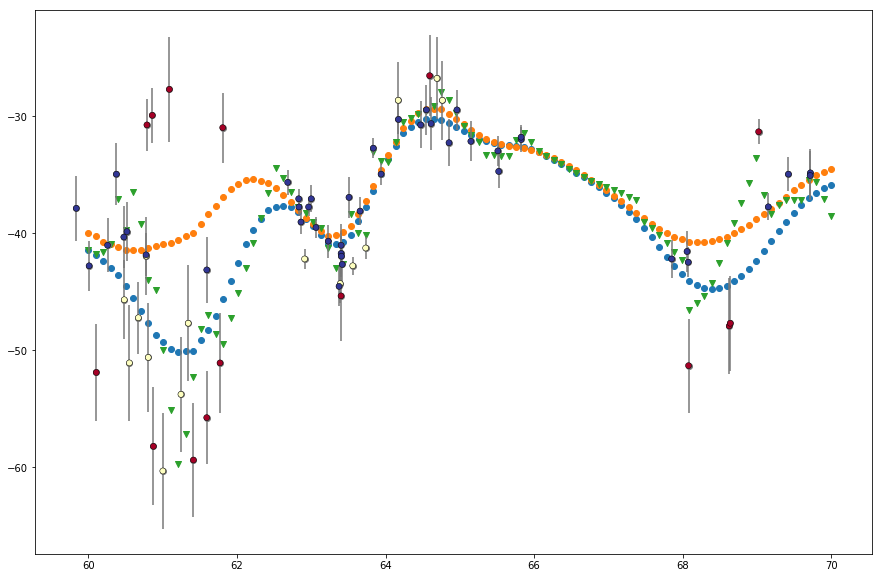

In [21]:
fig = plt.figure(figsize=(15, 10), facecolor=None)
ax1  = plt.subplot(111)
ax1.scatter(lls['lat'], -moho_line1)
ax1.scatter(lls['lat'], -moho_line2)
ax1.scatter(lls['lat'], -moho_lineR, marker="v")


ax1.errorbar(mohoraw['lat'][pts], -mohoraw['moh'][pts], yerr=np.abs(mohoraw['variance'][pts]), fmt='o', color="#777777")
# ax1.errorbar(mohoraw['lat'][pts], -mohoraw['mean_err'][pts]-mohoraw['moh'][pts], yerr=np.abs(mohoraw['variance'][pts]), fmt='s', color="#777777")

ax1.scatter(mohoraw['lat'][pts], -mohoraw['moh'][pts], c=mohoraw['q_score'][pts], 
            zorder=100, cmap=plt.cm.RdYlBu, linewidth=0.5, edgecolor="Black")


fig.savefig("MohiMoloXsections.png", dpi=600)
pass

In [20]:
mohoraw['q_score'][pts].max()

2.1